In [ ]:
############################################################
#   THETA–GAMMA NETWORK WITH OVERLAPPING PLACE-FIELD INPUT  #
#          USING IZHIKEVICH NEURONS IN BRIAN2                #
############################################################

import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Uncomment the following lines if you want to run on CUDA:
# import brian2cuda
# set_device("cuda_standalone")

start_scope()

################################################################################
#                                MODEL PARAMETERS
################################################################################

# Simulation parameters
duration = 5*second
defaultclock.dt = 0.1*ms

# Network structure: Excitatory, SST (inhibitory), and PV (inhibitory)
N_subgroups = 10          # Number of subgroups (each with a distinct Gaussian place field)
M = 20                    # Number of excitatory neurons per subgroup
N_exc = N_subgroups * M   # Total number of excitatory cells

N_SST_per_subgroup = 5    # Number of SST interneurons per subgroup
N_SST = N_subgroups * N_SST_per_subgroup  # Total SST cells

N_PV = 40                 # Total number of PV interneurons

# 1D environment for place cells
L = 1.0
overlap = 0.7
place_centers = np.linspace(0, L, N_subgroups)
place_centers = L/2 + overlap*(place_centers - L/2)

# Motion parameters and place-field tuning
speed = L/(duration/second)
sigma_place = 0.15
rate_peak = 250*Hz

# Izhikevich parameters for excitatory neurons
a_exc  = 0.02
b_exc  = 0.2
c_exc  = -65
d_exc  = 8
tau_AHP_exc = 100*ms

# Izhikevich parameters for inhibitory SST cells
a_SST  = 0.02
b_SST  = 0.25
c_SST  = -65
d_SST  = 2

# Izhikevich parameters for inhibitory PV cells
a_PV   = 0.1
b_PV   = 0.2
c_PV   = -65
d_PV   = 2
# Remove the tonic drive from PV cells (it will be replaced by noisy Poisson input)
PV_tonic_current = 0.0

# Synaptic time constants
tau_AMPA = 5*ms
tau_NMDA = 100*ms
tau_GABA_A = 10*ms
tau_GABA_B = 50*ms

# Synaptic weights for various connections
w_AMPA_in   = 0.2        # Poisson input --> Excitatory cells
w_AMPA_subg = 0.1        # Recurrent excitation within an Exc subgroup
w_Exc_SST   = 1.         # Weight for connections between Exc and SST cells
w_SST_Exc   = 0#0.15     # Weight for connections between SST and Exc cells (mutual inhibition)
w_PV        = 10.         # Recurrent connectivity to generate oscillations

# Weak synaptic weights for PV-related connections.
w_PV_global = 0#0.02     # Used in Exc-->PV, PV-->Exc, and PV-->SST connections

w_NMDA_subg = 0#0.01     # Weight for NMDA synapses connecting different Exc subgroups (plastic)

# STDP parameters for NMDA connections (between excitatory cells from different subgroups)
tau_pre_stdp = 20*ms
tau_post_stdp = 20*ms
A_pre = 0#0.0005
A_post = 0#-0.0005
wmax = 0.2

# New parameters for PV noisy input drive:
noisy_PV_rate = 100*Hz   # Constant rate for noisy input to PV cells
w_noisy_PV = 0.2        # Weight for Poisson --> PV synapses
N_PV_noise = 40         # Number of Poisson noise sources for PV neurons

################################################################################
#                          IZHIKEVICH EQUATIONS
################################################################################

# Excitatory neuron equations (with an afterhyperpolarization current I_AHP)
eqs_exc = '''
dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn - I_AHP)/ms : 1
du/dt = a*(b*v - u)/ms : 1
I_syn = I_AMPA + I_NMDA + I_GABA_A + I_GABA_B : 1
dI_AMPA/dt = -I_AMPA/tau_AMPA : 1
dI_NMDA/dt = -I_NMDA/tau_NMDA : 1
dI_GABA_A/dt = -I_GABA_A/tau_GABA_A : 1
dI_GABA_B/dt = -I_GABA_B/tau_GABA_B : 1
dI_AHP/dt = -I_AHP/tau_AHP_exc : 1
a : 1
b : 1
'''

# Inhibitory neuron equations (for both SST and PV, with placeholder for tonic input)
eqs_inh = '''
dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn + I_tonic)/ms : 1
du/dt = a*(b*v - u)/ms : 1
I_syn = I_AMPA + I_NMDA + I_GABA_A + I_GABA_B : 1
dI_AMPA/dt = -I_AMPA/tau_AMPA : 1
dI_NMDA/dt = -I_NMDA/tau_NMDA : 1
dI_GABA_A/dt = -I_GABA_A/tau_GABA_A : 1
dI_GABA_B/dt = -I_GABA_B/tau_GABA_B : 1
I_tonic : 1
a : 1
b : 1
'''

# Reset rules for excitatory and inhibitory neurons
reset_exc = '''
v = -65
u += 8
I_AHP += 1
'''

reset_inh_SST = '''
v = -65
u += 2
'''

reset_inh_PV = '''
v = -65
u += 2
'''

################################################################################
#                          CREATE NEURON GROUPS
################################################################################

# Excitatory neuron group
G_exc = NeuronGroup(N_exc, model=eqs_exc, threshold='v >= 30',
                    reset=reset_exc, method='euler')
G_exc.v = -65
G_exc.u = 0
G_exc.I_AHP = 0
G_exc.a = a_exc
G_exc.b = b_exc

# SST inhibitory neuron group
G_SST = NeuronGroup(N_SST, model=eqs_inh, threshold='v >= 30',
                    reset=reset_inh_SST, method='euler')
G_SST.v = -65
G_SST.u = 0
G_SST.I_tonic = 0
G_SST.a = a_SST
G_SST.b = b_SST

# PV inhibitory neuron group (without intrinsic tonic drive)
G_PV = NeuronGroup(N_PV, model=eqs_inh, threshold='v >= 30',
                   reset=reset_inh_PV, method='euler')
G_PV.v = -65
G_PV.u = 0
G_PV.I_tonic = 0      # No intrinsic tonic input, will be driven by noisy input
G_PV.a = a_PV
G_PV.b = b_PV

################################################################################
#                          CREATE PLACE-CELL INPUTS FOR EXCITATORY CELLS
################################################################################

def place_rate_function(t):
    pos = speed * (t/second)
    rates = np.zeros(N_subgroups) * Hz
    for idx, center in enumerate(place_centers):
        val = rate_peak * exp(-0.5*((pos - center)/sigma_place)**2)
        rates[idx] = val
    return rates

num_steps = int(duration/defaultclock.dt)
time_array = np.arange(num_steps)*defaultclock.dt

rates_array = np.zeros((N_subgroups, num_steps)) * Hz
for n in range(num_steps):
    t_ = time_array[n]
    rates_array[:, n] = place_rate_function(t_)

# Create a PoissonGroup for each excitatory subgroup's place-tuned input.
PG_place = []
M_spike_in = []  # Spike monitors for the place input groups (if needed)
for sg in range(N_subgroups):
    rate_timed_array = TimedArray(rates_array[sg], dt=defaultclock.dt)
    PG = PoissonGroup(100, rates='rate_fn(t)', namespace={'rate_fn': rate_timed_array})
    PG_place.append(PG)
    M_spike_in.append(SpikeMonitor(PG))

################################################################################
#                ADD NOISY POISSON INPUT TO PV NEURONS
################################################################################

# Poisson group providing constant noisy drive to PV cells.
PG_PV = PoissonGroup(N_PV_noise, rates=noisy_PV_rate)

################################################################################
#                                SYNAPSES
################################################################################

# 1. Connect place-cell Poisson inputs to the corresponding excitatory subgroup.
S_in_exc = []
for sg in range(N_subgroups):
    i_start = sg * M
    i_end   = (sg+1) * M
    syn = Synapses(
        PG_place[sg],
        G_exc[i_start:i_end],
        on_pre='I_AMPA_post += w_AMPA_in'
    )
    # Increase connection probability to ensure robust drive from each Gaussian.
    syn.connect(p=0.8)
    S_in_exc.append(syn)

# 2. Local recurrent excitatory connections within each Exc subgroup (via AMPA).
S_AMPA_subg = Synapses(G_exc, G_exc, on_pre='I_AMPA_post += w_AMPA_subg')
for sg in range(N_subgroups):
    i_start = sg * M
    i_end   = (sg+1) * M
    # All-to-all connectivity within the subgroup using Cartesian product.
    S_AMPA_subg.connect(i=np.repeat(np.arange(i_start, i_end), M),
                        j=np.tile(np.arange(i_start, i_end), M))

# 3. Plastic NMDA connections (with STDP) connecting Exc neurons across different subgroups.
eqs_stdp = '''
xpre : 1
xpost : 1
'''
on_pre_stdp = '''
I_NMDA_post += w
xpre = 1
w = clip(w + A_pre*xpost, 0, wmax)
'''
on_post_stdp = '''
xpost = 1
w = clip(w + A_post*xpre, 0, wmax)
'''

S_NMDA = Synapses(G_exc, G_exc,
                  model='w : 1\n' + eqs_stdp,
                  on_pre=on_pre_stdp,
                  on_post=on_post_stdp)
for sg in range(N_subgroups):
    i_start = sg * M
    i_end   = (sg+1) * M
    for sg2 in range(N_subgroups):
        if sg2 != sg:
            j_start = sg2 * M
            j_end   = (sg2+1) * M
            S_NMDA.connect(i=np.repeat(np.arange(i_start, i_end), M),
                           j=np.tile(np.arange(j_start, j_end), M))
S_NMDA.w = w_NMDA_subg

# 4. Connections from Excitatory cells to local SST interneurons.
# Here, we create all-to-all connectivity between each excitatory subgroup and its local SST subgroup.
S_E_SST = Synapses(G_exc, G_SST, on_pre='I_AMPA_post += w_Exc_SST')
for sg in range(N_subgroups):
    i_start = sg * M
    i_end   = (sg+1) * M
    i_sst_start = sg * N_SST_per_subgroup
    i_sst_end   = (sg + 1) * N_SST_per_subgroup
    S_E_SST.connect(i=np.repeat(np.arange(i_start, i_end), N_SST_per_subgroup),
                    j=np.tile(np.arange(i_sst_start, i_sst_end), M))

# 5. SST interneurons mediate lateral inhibition:
# Each SST subgroup inhibits all excitatory neurons outside its own subgroup.
S_SST_E = Synapses(G_SST, G_exc, on_pre='I_GABA_A_post += w_SST_Exc')
for sg in range(N_subgroups):
    i_sst_start = sg * N_SST_per_subgroup
    i_sst_end   = (sg + 1) * N_SST_per_subgroup
    for sg2 in range(N_subgroups):
        if sg2 != sg:  # inhibit excitatory neurons in other subgroups
            j_start = sg2 * M
            j_end   = (sg2+1) * M
            S_SST_E.connect(i=np.repeat(np.arange(i_sst_start, i_sst_end), M),
                            j=np.tile(np.arange(j_start, j_end), N_SST_per_subgroup))

# 6. PV interneuron connections:
# a. Noisy input to PV cells from a dedicated Poisson group.
S_noisy_PV = Synapses(PG_PV, G_PV, on_pre='I_AMPA_post += w_noisy_PV')
S_noisy_PV.connect(p=0.8)

# b. Excitatory (E) to PV connections (made relatively weak).
S_E_PV = Synapses(G_exc, G_PV, on_pre='I_AMPA_post += w_PV_global')
S_E_PV.connect()

# c. PV cells inhibit excitatory cells.
S_PV_E = Synapses(G_PV, G_exc, on_pre='I_GABA_B_post += w_PV_global')
S_PV_E.connect()

# d. PV cells inhibit other PV cells (recurrent inhibition).
S_PV_PV = Synapses(G_PV, G_PV, on_pre='I_GABA_B_post += w_PV')
S_PV_PV.connect()

# e. Additionally, PV cells inhibit SST cells (to help synchronize network rhythm).
S_PV_SST = Synapses(G_PV, G_SST, on_pre='I_GABA_B_post += w_PV_global')
S_PV_SST.connect()

################################################################################
#                                MONITORS
################################################################################

# Monitor spikes and membrane potentials of Excitatory cells.
M_spike_exc = SpikeMonitor(G_exc, record=True)
M_state_exc = StateMonitor(G_exc, 'v', record=True, dt=0.5*ms)

# Monitor spikes and membrane potentials of SST inhibitory cells.
M_spike_SST = SpikeMonitor(G_SST, record=True)
M_state_SST = StateMonitor(G_SST, 'v', record=True, dt=0.5*ms)

# Monitor spikes and membrane potentials of PV inhibitory cells.
M_spike_pv = SpikeMonitor(G_PV, record=True)
M_state_pv = StateMonitor(G_PV, 'v', record=True, dt=0.5*ms)

################################################################################
#                               RUN SIMULATION
################################################################################

print("Starting simulation...")

# Explicitly build the full network with all defined components.
net = Network(collect())

# Add all Poisson input groups and their monitors to the network.
for pg, mon in zip(PG_place, M_spike_in):
    net.add(pg)
    net.add(mon)

# Add the PV noisy input group.
net.add(PG_PV)
net.add(S_noisy_PV)

# Run the simulation.
net.run(duration)

print("Simulation finished.")

In [ ]:
plt.figure()
colors = ['r','g','b','k','m','y']  # or pick any set of colors
for i, mon in enumerate(M_spike_in):
    t_spikes = mon.t
    i_spikes = np.ones_like(t_spikes)*i  # just to visually separate them
    plt.plot(t_spikes/ms, i_spikes, '.', label=f"Group {i}", color=colors[i % len(colors)])
plt.xlabel("Time (ms)")
plt.ylabel("PoissonGroup index")
plt.title("Poisson input spike raster")
plt.legend()
plt.show()

# Izhikevich neurons

### Without recurrent PV connections (constant input driven PV population)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Uncomment to run on CUDA
# import brian2cuda
# set_device('cuda_standalone')

start_scope()

################################################################################
#                                MODEL PARAMETERS
################################################################################

duration = 5*second
defaultclock.dt = 0.1*ms

N_subgroups = 10          # Number of place-field subgroups
M = 20                    # Excitatory neurons per subgroup
N_exc = N_subgroups * M   # Total excitatory cells

N_SST_per_subgroup = 5    # SST interneurons per subgroup
N_SST = N_subgroups * N_SST_per_subgroup

N_PV = 200                 # Total PV interneurons

# 1D environment for place cells
L = 1.0
overlap = 0.7
place_centers = np.linspace(0, L, N_subgroups)
place_centers = L/2 + overlap*(place_centers - L/2)

speed = L/(duration/second)
sigma_place = 0.15
rate_peak = 160*Hz

# Izhikevich parameters
# Excitatory
a_exc, b_exc, c_exc, d_exc = 0.02, 0.2, -65, 8
tau_AHP_exc = 50*ms
# SST interneurons
a_SST, b_SST, c_SST, d_SST = 0.02, 0.25, -65, 2
# PV interneurons
a_PV, b_PV, c_PV, d_PV = 0.1, 0.2, -65, 2

# Synaptic time constants
tau_AMPA, tau_NMDA = 5*ms, 100*ms
tau_GABA_A, tau_GABA_B = 10*ms, 80*ms

# Synaptic weights
w_AMPA_in    = 0.2    # Poisson → Exc
w_AMPA_subg  = 0.1    # E → E within subgroup
w_Exc_SST    = 2.    # E → SST
w_SST_Exc    = 4.   # SST → E (lateral inhibition)
w_Exc_PV     = 0      # Osc freq modulation of PV population
w_PV_Exc     = 0      # Osc inhibition (around 5 Hz)
w_PV_SST     = 0
w_PV_PV      = 3.    # PV → PV recurrent inhibition
w_AHP        = 1      # after-spike hyperpolarization for Exc neurons

# PV noisy drive (constant)
noisy_PV_rate = 800*Hz
w_noisy_PV   = 0.1
N_PV_noise   = 20

################################################################################
#                          IZHICKEVICH EQUATIONS
################################################################################

eqs_exc = '''
 dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn - I_AHP)/ms : 1
 du/dt = a*(b*v - u)/ms                           : 1
 I_syn = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B    : 1
 dI_AMPA/dt = -I_AMPA/tau_AMPA                   : 1
 dI_NMDA/dt = -I_NMDA/tau_NMDA                   : 1
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A             : 1
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B             : 1
 dI_AHP/dt   = -I_AHP/tau_AHP_exc                : 1
 a : 1
 b : 1
'''

eqs_inh = '''
 dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn       )/ms : 1
 du/dt = a*(b*v - u)/ms                                  : 1
 I_syn = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B           : 1
 dI_AMPA/dt = -I_AMPA/tau_AMPA                          : 1
 dI_NMDA/dt = -I_NMDA/tau_NMDA                          : 1
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A                    : 1
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B                    : 1
 a : 1
 b : 1
'''

reset_exc   = 'v = -65; u += d_exc; I_AHP += w_AHP'
reset_inh_S = 'v = -65; u += d_SST'
reset_inh_P = 'v = -65; u += d_PV'

################################################################################
#                          CREATE NEURON GROUPS
################################################################################

G_exc = NeuronGroup(N_exc, model=eqs_exc, threshold='v>=30',
                    reset=reset_exc, method='euler')
G_exc.v = c_exc; G_exc.u = 0; G_exc.I_AHP = 0
G_exc.a = a_exc; G_exc.b = b_exc

G_SST = NeuronGroup(N_SST, model=eqs_inh, threshold='v>=30',
                    reset=reset_inh_S, method='euler')
G_SST.v = c_SST; G_SST.u = 0
G_SST.a = a_SST; G_SST.b = b_SST

G_PV = NeuronGroup(N_PV, model=eqs_inh, threshold='v>=30',
                   reset=reset_inh_P, method='euler')
G_PV.v = c_PV; G_PV.u = 0
G_PV.a = a_PV; G_PV.b = b_PV

################################################################################
#                COMPUTE PLACE-FIELD RATE ARRAY
################################################################################

num_steps   = int(duration/defaultclock.dt)
rates_array = np.zeros((N_subgroups, num_steps))*Hz
for ti in range(num_steps):
    current_time = ti * defaultclock.dt
    pos = speed * (current_time / second)
    for sg in range(N_subgroups):
        rates_array[sg, ti] = rate_peak * np.exp(-0.5 * ((pos - place_centers[sg]) / sigma_place)**2)

################################################################################
#      TIME-VARYING POISSONGROUP → Synapses (place inputs)
################################################################################

PG_place = []
S_in_exc = []
for sg in range(N_subgroups):
    rate_name = f'r{sg}'
    rate_ta   = TimedArray(rates_array[sg], dt=defaultclock.dt)
    PG = PoissonGroup(100, rates=f'{rate_name}(t)', namespace={rate_name: rate_ta})
    PG_place.append(PG)

    start, end = sg*M, (sg+1)*M
    syn = Synapses(PG, G_exc[start:end], on_pre='I_AMPA_post += w_AMPA_in')
    syn.connect(p=0.8)
    S_in_exc.append(syn)

################################################################################
#             CONSTANT POISSON INPUT FOR PV NOISY DRIVE
################################################################################

Pi_PV = PoissonInput(G_PV, 'I_AMPA', N=N_PV_noise,
                     rate=noisy_PV_rate, weight=w_noisy_PV)

################################################################################
#                                SYNAPSES
################################################################################

S_AMPA_subg = Synapses(G_exc, G_exc, on_pre='I_AMPA_post += w_AMPA_subg')
for sg in range(N_subgroups):
    i0, i1 = sg*M, (sg+1)*M
    S_AMPA_subg.connect(i=range(i0, i1), j=range(i0, i1))

# E to SST: each E subgroup excites only its matching SST subgroup
S_E_SST = Synapses(G_exc, G_SST, on_pre='I_AMPA_post += w_Exc_SST')
for sg in range(N_subgroups):
    i0, i1 = sg * M, (sg + 1) * M                     # E subgroup
    j0, j1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # matching SST subgroup
    pre  = np.repeat(np.arange(i0, i1), j1 - j0)
    post = np.tile(np.arange(j0, j1), i1 - i0)
    S_E_SST.connect(i=pre, j=post)

# SST to E: each SST subgroup inhibits all E subgroups except its own
S_SST_E = Synapses(G_SST, G_exc, on_pre='I_GABA_A_post += w_SST_Exc')
for sg in range(N_subgroups):
    i0, i1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # SST subgroup
    for sg2 in range(N_subgroups):
        if sg2 == sg:
            continue  # skip self
        j0, j1 = sg2 * M, (sg2 + 1) * M             # E subgroup to be inhibited
        pre  = np.repeat(np.arange(i0, i1), j1 - j0)
        post = np.tile(np.arange(j0, j1), i1 - i0)
        S_SST_E.connect(i=pre, j=post)

S_PV_PV = Synapses(G_PV, G_PV, on_pre='I_GABA_B_post += w_PV_PV')
S_PV_PV.connect(p=0.2)

S_E_PV = Synapses(G_exc, G_PV, on_pre='I_AMPA_post += w_Exc_PV')
S_E_PV.connect()
S_PV_E = Synapses(G_PV, G_exc, on_pre='I_GABA_B_post += w_PV_Exc')
S_PV_E.connect()

S_PV_SST = Synapses(G_PV, G_SST, on_pre='I_GABA_B_post += w_PV_SST')
S_PV_SST.connect()

################################################################################
#                                MONITORS
################################################################################

M_spike_exc = SpikeMonitor(G_exc, record=True)
M_state_exc = StateMonitor(G_exc, 'v', record=True, dt=0.5*ms)
M_spike_SST = SpikeMonitor(G_SST, record=True)
M_state_SST = StateMonitor(G_SST, 'v', record=True, dt=0.5*ms)
M_spike_pv  = SpikeMonitor(G_PV, record=True)
M_state_pv  = StateMonitor(G_PV, 'v', record=True, dt=0.5*ms)
M_Iinh_pv = StateMonitor(G_PV, 'I_GABA_B', record=True)

################################################################################
#                               RUN SIMULATION
################################################################################

print('Starting simulation...')
net = Network()
net.add(G_exc, G_SST, G_PV)
net.add(S_AMPA_subg, S_E_SST, S_SST_E, S_PV_PV, S_E_PV, S_PV_E, Pi_PV)
net.add(M_spike_exc, M_state_exc, M_spike_SST, M_state_SST, M_spike_pv, M_state_pv, M_Iinh_pv)
for pg, syn in zip(PG_place, S_in_exc):
    net.add(pg)
    net.add(syn)
net.run(duration)
print('Simulation finished.')

Starting simulation...
Simulation finished.


### Self-contained circuit with recurrent PV connections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from brian2 import *

# Uncomment to run on CUDA
# import brian2cuda
# set_device('cuda_standalone')

start_scope()

################################################################################
#                                MODEL PARAMETERS
################################################################################

duration = 10*second
defaultclock.dt = 0.1*ms

N_subgroups = 10          # Number of place-field subgroups
M = 20                    # Excitatory neurons per subgroup
N_exc = N_subgroups * M   # Total excitatory cells

N_SST_per_subgroup = 5    # SST interneurons per subgroup
N_SST = N_subgroups * N_SST_per_subgroup

N_PV = 200                 # Total PV interneurons

# 1D environment for place cells
L = 1.0
overlap = 0.7
place_centers = np.linspace(0, L, N_subgroups)
place_centers = L/2 + overlap*(place_centers - L/2)
place_centers = place_centers - (place_centers - L/2)/3  # added for skeness
place_centers += L/4                                     # added for skeness

speed = L/(duration/second)
sigma_place = 0.2
rate_peak = 160*Hz

# Izhikevich parameters
# Excitatory
a_exc, b_exc, c_exc, d_exc = 0.02, 0.2, -65, 8
tau_AHP_exc = 150*ms
# SST interneurons
a_SST, b_SST, c_SST, d_SST = 0.02, 0.25, -65, 2
# PV interneurons
a_PV, b_PV, c_PV, d_PV = 0.1, 0.2, -65, 2

# Synaptic time constants
tau_AMPA, tau_NMDA = 5*ms, 100*ms
tau_GABA_A, tau_GABA_B = 10*ms, 100*ms

# Synaptic weights
w_AMPA_in    = 0.2    # Poisson → Exc
w_AMPA_subg  = 0.5    # E → E within subgroup
w_Exc_SST    = 1.    # E → SST
w_SST_Exc    = 4.   # SST → E (lateral inhibition)
w_Exc_PV     = 0.2      # Osc freq modulation of PV population
w_PV_Exc     = 0.35      # Osc inhibition (around 5 Hz)
w_PV_SST     = 0
w_PV_PV      = 0.    # PV → PV recurrent inhibition
w_AHP        = 8.      # after-spike hyperpolarization for Exc neurons

################################################################################
#                          IZHICKEVICH EQUATIONS
################################################################################

eqs_exc = '''
 dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn - I_AHP)/ms : 1
 du/dt = a*(b*v - u)/ms                           : 1
 I_syn = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B    : 1
 dI_AMPA/dt = -I_AMPA/tau_AMPA                   : 1
 dI_NMDA/dt = -I_NMDA/tau_NMDA                   : 1
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A             : 1
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B             : 1
 dI_AHP/dt   = -I_AHP/tau_AHP_exc                : 1
 a : 1
 b : 1
'''

eqs_inh = '''
 dv/dt = (0.04*v*v + 5*v + 140 - u + I_syn       )/ms : 1
 du/dt = a*(b*v - u)/ms                                  : 1
 I_syn = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B           : 1
 dI_AMPA/dt = -I_AMPA/tau_AMPA                          : 1
 dI_NMDA/dt = -I_NMDA/tau_NMDA                          : 1
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A                    : 1
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B                    : 1
 a : 1
 b : 1
'''

reset_exc   = 'v = -65; u += d_exc; I_AHP += w_AHP'
reset_inh_S = 'v = -65; u += d_SST'
reset_inh_P = 'v = -65; u += d_PV'

################################################################################
#                          CREATE NEURON GROUPS
################################################################################

G_exc = NeuronGroup(N_exc, model=eqs_exc, threshold='v>=30',
                    reset=reset_exc, method='euler')
G_exc.v = c_exc; G_exc.u = 0; G_exc.I_AHP = 0
G_exc.a = a_exc; G_exc.b = b_exc

G_SST = NeuronGroup(N_SST, model=eqs_inh, threshold='v>=30',
                    reset=reset_inh_S, method='euler')
G_SST.v = c_SST; G_SST.u = 0
G_SST.a = a_SST; G_SST.b = b_SST

G_PV = NeuronGroup(N_PV, model=eqs_inh, threshold='v>=30',
                   reset=reset_inh_P, method='euler')
G_PV.v = c_PV; G_PV.u = 0
G_PV.a = a_PV; G_PV.b = b_PV

################################################################################
#                COMPUTE PLACE-FIELD RATE ARRAY
################################################################################

# Vectorized rate computation
# Reshape so broadcasting works: (N_subgroups, 1) - (1, num_steps)
num_steps = int(duration / defaultclock.dt)
t_ = np.arange(num_steps) * defaultclock.dt
positions = speed * (t_ / second)  # (num_steps,) array
pos_grid = positions[None, :]  # shape (1, num_steps)
center_grid = place_centers[:, None]  # shape (N_subgroups, 1)

# Skewnorm PDF
rates_array = rate_peak * skewnorm.pdf(pos_grid, a=-20, loc=center_grid, scale=sigma_place)  # shape (N_subgroups, num_steps)

'''
num_steps   = int(duration/defaultclock.dt)
rates_array = np.zeros((N_subgroups, num_steps))*Hz
for ti in range(num_steps):
    current_time = ti * defaultclock.dt
    pos = speed * (current_time / second)
    for sg in range(N_subgroups):
        #rates_array[sg, ti] = rate_peak * np.exp(-0.5 * ((pos - place_centers[sg]) / sigma_place)**2)
        rates_array[sg, ti] = rate_peak * skewnorm.pdf(pos, a=0, loc=place_centers[sg], scale=sigma_place)
'''

################################################################################
#      TIME-VARYING POISSONGROUP → Synapses (place inputs)
################################################################################

PG_place = []
S_in_exc = []
for sg in range(N_subgroups):
    rate_name = f'r{sg}'
    rate_ta   = TimedArray(rates_array[sg], dt=defaultclock.dt)
    PG = PoissonGroup(100, rates=f'{rate_name}(t)', namespace={rate_name: rate_ta})
    PG_place.append(PG)

    start, end = sg*M, (sg+1)*M
    syn = Synapses(PG, G_exc[start:end], on_pre='I_AMPA_post += w_AMPA_in')
    syn.connect(p=0.8)
    S_in_exc.append(syn)

################################################################################
#                                SYNAPSES
################################################################################

S_AMPA_subg = Synapses(G_exc, G_exc, on_pre='I_AMPA_post += w_AMPA_subg')
for sg in range(N_subgroups):
    i0, i1 = sg*M, (sg+1)*M
    S_AMPA_subg.connect(i=range(i0, i1), j=range(i0, i1))

# E to SST: each E subgroup excites only its matching SST subgroup
S_E_SST = Synapses(G_exc, G_SST, on_pre='I_AMPA_post += w_Exc_SST')
for sg in range(N_subgroups):
    i0, i1 = sg * M, (sg + 1) * M                     # E subgroup
    j0, j1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # matching SST subgroup
    pre  = np.repeat(np.arange(i0, i1), j1 - j0)
    post = np.tile(np.arange(j0, j1), i1 - i0)
    S_E_SST.connect(i=pre, j=post)

# SST to E: each SST subgroup inhibits all E subgroups except its own
S_SST_E = Synapses(G_SST, G_exc, on_pre='I_GABA_A_post += w_SST_Exc')
for sg in range(N_subgroups):
    i0, i1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # SST subgroup
    for sg2 in range(N_subgroups):
        if sg2 == sg:
            continue  # skip self
        j0, j1 = sg2 * M, (sg2 + 1) * M             # E subgroup to be inhibited
        pre  = np.repeat(np.arange(i0, i1), j1 - j0)
        post = np.tile(np.arange(j0, j1), i1 - i0)
        S_SST_E.connect(i=pre, j=post)

S_PV_PV = Synapses(G_PV, G_PV, on_pre='I_GABA_B_post += w_PV_PV')
S_PV_PV.connect(p=0.2)

S_E_PV = Synapses(G_exc, G_PV, on_pre='I_AMPA_post += w_Exc_PV')
S_E_PV.connect(p=1)

S_PV_E = Synapses(G_PV, G_exc, on_pre='I_GABA_B_post += w_PV_Exc')
S_PV_E.connect(p=1)

S_PV_SST = Synapses(G_PV, G_SST, on_pre='I_GABA_B_post += w_PV_SST')
S_PV_SST.connect(p=0.8)

################################################################################
#                                MONITORS
################################################################################

M_spike_exc = SpikeMonitor(G_exc, record=True)
M_state_exc = StateMonitor(G_exc, 'v', record=True, dt=0.5*ms)
M_spike_SST = SpikeMonitor(G_SST, record=True)
M_state_SST = StateMonitor(G_SST, 'v', record=True, dt=0.5*ms)
M_spike_pv  = SpikeMonitor(G_PV, record=True)
M_state_pv  = StateMonitor(G_PV, 'v', record=True, dt=0.5*ms)
M_Iinh_pv = StateMonitor(G_PV, 'I_GABA_B', record=True)

################################################################################
#                               RUN SIMULATION
################################################################################

print('Starting simulation...')
net = Network()
net.add(G_exc, G_SST, G_PV)
net.add(S_AMPA_subg, S_E_SST, S_SST_E, S_PV_PV, S_E_PV, S_PV_E)
net.add(M_spike_exc, M_state_exc, M_spike_SST, M_state_SST, M_spike_pv, M_state_pv, M_Iinh_pv)
for pg, syn in zip(PG_place, S_in_exc):
    net.add(pg)
    net.add(syn)
net.run(duration)
print('Simulation finished.')

Starting simulation...
Simulation finished.


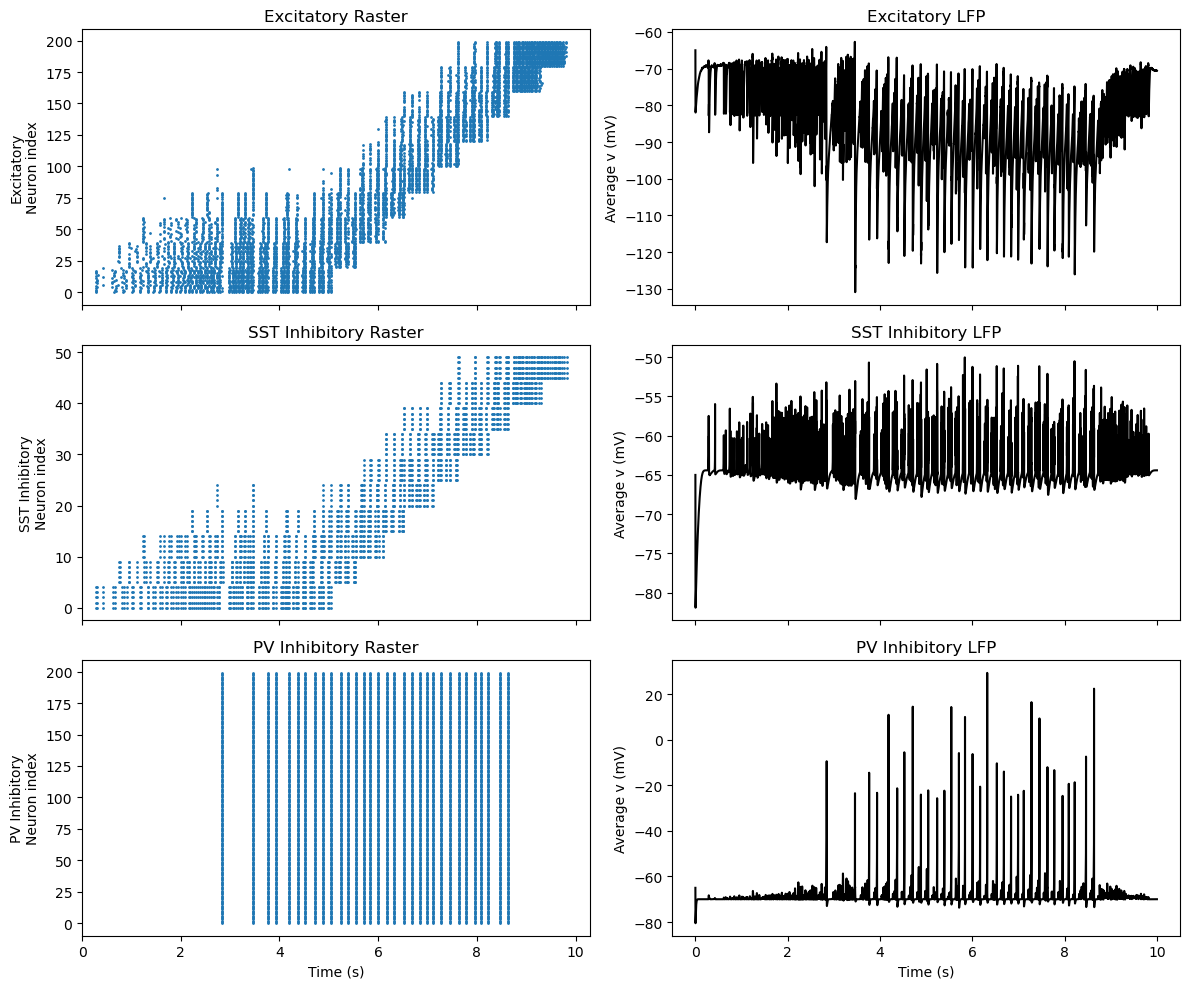

In [2]:
# Convert simulation time from Brian2 units (default: seconds) to a numpy array.
# Here, we assume the state monitors for excitatory cells have recorded the time vector.
time = M_state_exc.t / second  # time in seconds

# Compute the LFPs as the average membrane potential in each population.
LFP_exc = np.mean(M_state_exc.v, axis=0)
LFP_SST = np.mean(M_state_SST.v, axis=0)
LFP_pv  = np.mean(M_state_pv.v, axis=0)

# Create a figure with 3 rows (one per population) and 2 columns:
# left column: raster plot; right column: LFP trace.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex='col')
pop_labels = ['Excitatory', 'SST Inhibitory', 'PV Inhibitory']

# For each population: plot the raster and the LFP.
for i, (spike_mon, lfp, label) in enumerate(zip([M_spike_exc, M_spike_SST, M_spike_pv],
                                                  [LFP_exc, LFP_SST, LFP_pv],
                                                  pop_labels)):
    # Raster plot.
    ax_raster = axes[i, 0]
    # Plot each spike as a small dot; spike_mon.i gives neuron indices.
    ax_raster.plot(spike_mon.t/second, spike_mon.i, '.', markersize=2)
    ax_raster.set_ylabel(f'{label}\nNeuron index')
    ax_raster.set_title(f'{label} Raster')
    ax_raster.set_xlim(0)

    # LFP plot.
    ax_lfp = axes[i, 1]
    ax_lfp.plot(time, lfp, 'k')  # 'k' for a black line.
    ax_lfp.set_ylabel('Average v (mV)')
    ax_lfp.set_title(f'{label} LFP')

# Label the shared X-axis.
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

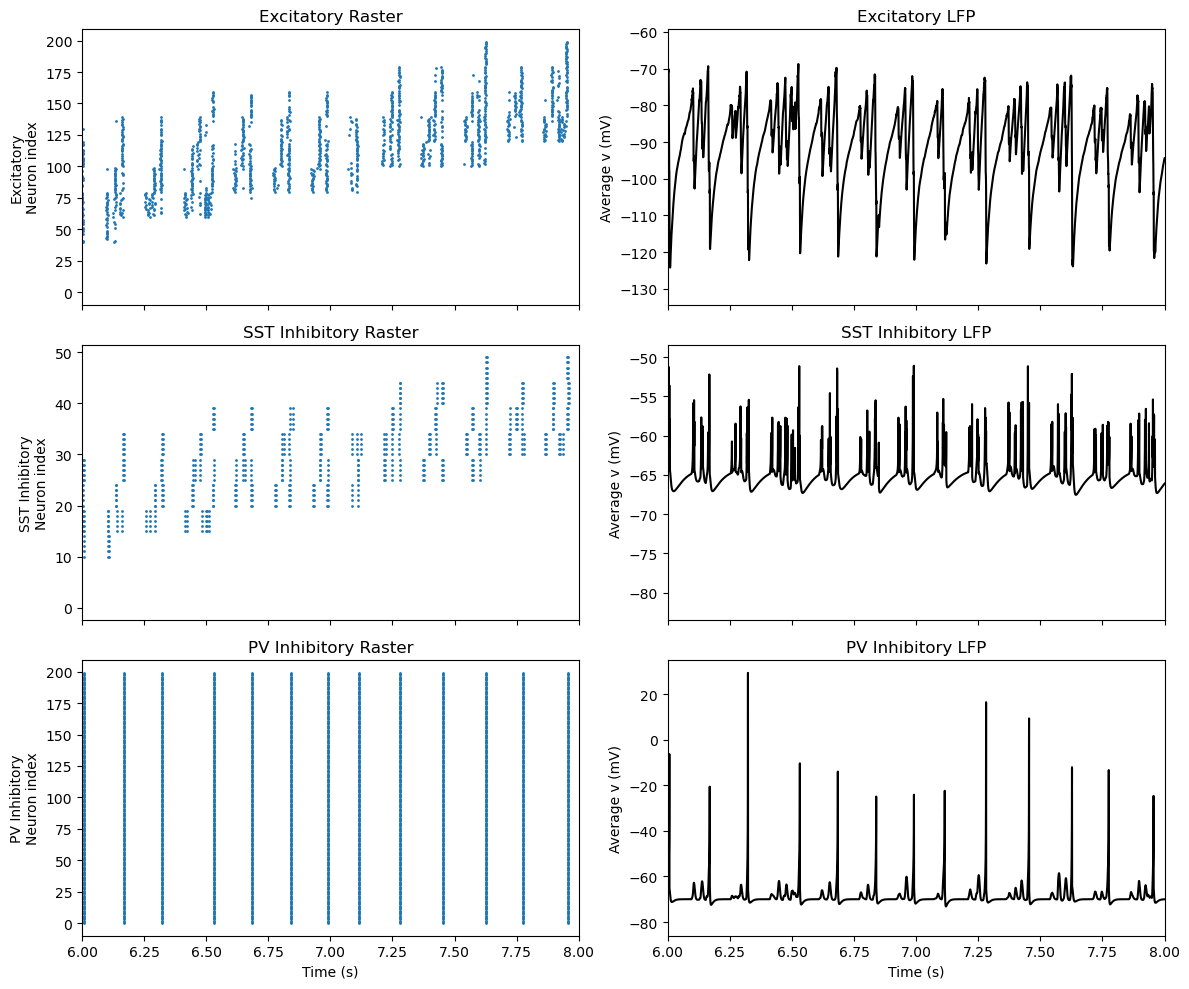

In [3]:
# Convert simulation time from Brian2 units (default: seconds) to a numpy array.
# Here, we assume the state monitors for excitatory cells have recorded the time vector.
time = M_state_exc.t / second  # time in seconds

# Compute the LFPs as the average membrane potential in each population.
LFP_exc = np.mean(M_state_exc.v, axis=0)
LFP_SST = np.mean(M_state_SST.v, axis=0)
LFP_pv  = np.mean(M_state_pv.v, axis=0)

# Create a figure with 3 rows (one per population) and 2 columns:
# left column: raster plot; right column: LFP trace.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex='col')
pop_labels = ['Excitatory', 'SST Inhibitory', 'PV Inhibitory']

# For each population: plot the raster and the LFP.
for i, (spike_mon, lfp, label) in enumerate(zip([M_spike_exc, M_spike_SST, M_spike_pv],
                                                  [LFP_exc, LFP_SST, LFP_pv],
                                                  pop_labels)):
    # Raster plot.
    ax_raster = axes[i, 0]
    # Plot each spike as a small dot; spike_mon.i gives neuron indices.
    ax_raster.plot(spike_mon.t/second, spike_mon.i, '.', markersize=2)
    ax_raster.set_ylabel(f'{label}\nNeuron index')
    ax_raster.set_title(f'{label} Raster')
    ax_raster.set_xlim(6,8)

    # LFP plot.
    ax_lfp = axes[i, 1]
    ax_lfp.plot(time, lfp, 'k')  # 'k' for a black line.
    ax_lfp.set_ylabel('Average v (mV)')
    ax_lfp.set_title(f'{label} LFP')
    ax_lfp.set_xlim(6,8)

# Label the shared X-axis.
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

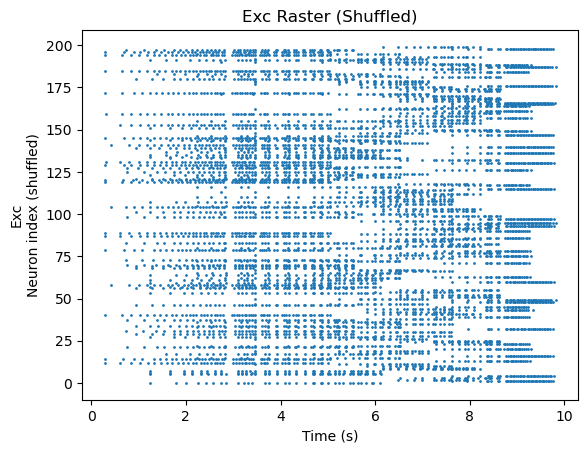

In [6]:
# Get unique neuron indices
unique_neurons = np.unique(M_spike_exc.i)

# Create a shuffled version of the neuron indices
shuffled_neurons = np.random.permutation(unique_neurons)

# Create a mapping from original index to shuffled index
shuffle_map = dict(zip(unique_neurons, shuffled_neurons))

# Apply the shuffle mapping
shuffled_indices = np.array([shuffle_map[i] for i in M_spike_exc.i])

# Plot the raster with shuffled indices
plt.figure()
plt.plot(M_spike_exc.t/second, shuffled_indices, '.', markersize=2)
plt.ylabel('Exc\nNeuron index (shuffled)')
plt.title('Exc Raster (Shuffled)')
plt.xlabel('Time (s)')
plt.show()

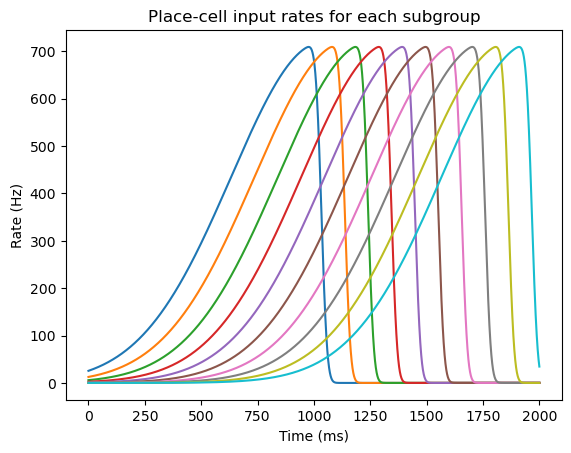

In [4]:
# Constants
L = 1.0
overlap = 0.7
sigma_place = 0.2
rate_peak = 180 * Hz
duration = 2*second  # Example duration
N_subgroups = 10     # Example number of subgroups

# Time setup
dt = defaultclock.dt
num_steps = int(duration / dt)
t = np.arange(num_steps) * dt
speed = L / (duration / second)
positions = speed * (t / second)  # (num_steps,) array

# Place field centers
place_centers = np.linspace(0, L, N_subgroups)
place_centers = L/2 + overlap*(place_centers - L/2)
place_centers = place_centers - (place_centers - L/2)/3
place_centers += L/4

# Vectorized rate computation
# Reshape so broadcasting works: (N_subgroups, 1) - (1, num_steps)
pos_grid = positions[None, :]  # shape (1, num_steps)
center_grid = place_centers[:, None]  # shape (N_subgroups, 1)

# Skewnorm PDF
rates_array = rate_peak * skewnorm.pdf(pos_grid, a=-20, loc=center_grid, scale=sigma_place)  # shape (N_subgroups, num_steps)

# Plot
for i in range(N_subgroups):
    plt.plot(t / ms, rates_array[i], label=f"Group {i}")
#plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Rate (Hz)")
plt.title("Place-cell input rates for each subgroup")
plt.show()

# LIF neurons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

start_scope()

################################################################################
#                           SIMULATION TIMING
################################################################################

duration = 5 * second
defaultclock.dt = 0.1 * ms

################################################################################
#                              NETWORK SIZES
################################################################################

N_subgroups = 10          # Number of place-field subgroups
M = 20                    # Excitatory neurons per subgroup
N_exc = N_subgroups * M   # Total excitatory cells

N_SST_per_subgroup = 5    # SST interneurons per subgroup
N_SST = N_subgroups * N_SST_per_subgroup

N_PV = 50                # Total PV interneurons

################################################################################
#                         SPATIAL INPUT PARAMETERS
################################################################################

L = 1.0                   # Environment length
overlap = 0.7
place_centers = np.linspace(0, L, N_subgroups)
place_centers = L/2 + overlap * (place_centers - L/2)

speed = L / (duration / second)
sigma_place = 0.2
rate_peak = 300 * Hz

################################################################################
#                        SYNAPTIC TIME CONSTANTS
################################################################################

tau_AMPA   = 5  * ms
tau_NMDA   = 100 * ms
tau_GABA_A = 10 * ms
tau_GABA_B = 50 * ms

################################################################################
#                            SYNAPTIC WEIGHTS
################################################################################

w_AMPA_in    = 0.01  * nA  # Poisson → Exc
w_AMPA_subg  = 0.1  * nA   # E → E within subgroup
w_Exc_SST    = 0.1  * nA   # E → SST
w_SST_Exc    = 0.15  * nA    # SST → E
w_Exc_PV     = 0.0  * nA   # E → PV (unused)
w_PV_Exc     = 0.0  * nA   # PV → E (unused)
w_PV_SST     = 0.0  * nA   # PV → SST (unused)
w_PV_PV      = 0.1 * nA     # PV → PV recurrent
w_noisy_PV   = 0.01  * nA  # Poisson → PV noisy drive

################################################################################
#                           NOISY PV DRIVE
################################################################################

noisy_PV_rate = 1000 * Hz
N_PV_noise    = 40

################################################################################
#                         LIF CELL PARAMETERS
################################################################################

# Pyramidal cells (Exc)
C_exc       = 107 * pF
R_exc       = 177 * Mohm
tau_ref_exc = 4.6 * ms
El_exc      = -75.5 * mV
Vth_exc     = -47.2 * mV
Vreset_exc  = -75.5 * mV
tau_AHP_exc = 50  * ms
w_AHP       = 1   * nA

# PV interneurons
C_PV        = 54.4 * pF
R_PV        = 126  * Mohm
tau_ref_PV  = 1.65 * ms
El_PV       = -75.2 * mV
Vth_PV      = -46.2 * mV
Vreset_PV   = -75.2 * mV

# SST interneurons
C_SST        = 71   * pF
R_SST        = 226  * Mohm
tau_ref_SST  = 2.1  * ms
El_SST       = -71.5 * mV
Vth_SST      = -46.0 * mV
Vreset_SST   = -71.5 * mV

################################################################################
#                            LIF EQUATIONS
################################################################################

# Excitatory LIF
eqs_LIF_exc = '''
 dv/dt    = (-(v - El_exc)/R_exc + I_syn - I_AHP)/C_exc : volt (unless refractory)
 dI_AMPA/dt   = -I_AMPA/tau_AMPA   : amp
 dI_NMDA/dt   = -I_NMDA/tau_NMDA   : amp
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A : amp
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B : amp
 dI_AHP/dt    = -I_AHP/tau_AHP_exc  : amp
 I_syn        = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B : amp
'''

# Inhibitory LIF (PV & SST)
eqs_LIF_inh = '''
 dv/dt    = (-(v - El)/R + I_syn)/C : volt (unless refractory)
 dI_AMPA/dt   = -I_AMPA/tau_AMPA   : amp
 dI_NMDA/dt   = -I_NMDA/tau_NMDA   : amp
 dI_GABA_A/dt = -I_GABA_A/tau_GABA_A : amp
 dI_GABA_B/dt = -I_GABA_B/tau_GABA_B : amp
 I_syn    = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B : amp
'''

################################################################################
#                          CREATE NEURON GROUPS
################################################################################

# Excitatory
global_exc_namespace = {
    'El_exc': El_exc, 'R_exc': R_exc, 'C_exc': C_exc,
    'tau_AMPA': tau_AMPA, 'tau_NMDA': tau_NMDA,
    'tau_GABA_A': tau_GABA_A, 'tau_GABA_B': tau_GABA_B,
    'tau_AHP_exc': tau_AHP_exc, 'w_AHP': w_AHP,
    'Vth_exc': Vth_exc, 'Vreset_exc': Vreset_exc
}
G_exc = NeuronGroup(
    N_exc, model=eqs_LIF_exc,
    threshold='v>Vth_exc', reset='v=Vreset_exc; I_AHP+=w_AHP',
    refractory=tau_ref_exc, method='euler', namespace=global_exc_namespace
)
G_exc.v = El_exc
G_exc.I_AMPA   = 0 * nA
G_exc.I_NMDA   = 0 * nA
G_exc.I_GABA_A = 0 * nA
G_exc.I_GABA_B = 0 * nA
G_exc.I_AHP    = 0 * nA

# SST interneurons
global_inh_SST_namespace = {
    'El': El_SST, 'R': R_SST, 'C': C_SST,
    'tau_AMPA': tau_AMPA, 'tau_NMDA': tau_NMDA,
    'tau_GABA_A': tau_GABA_A, 'tau_GABA_B': tau_GABA_B,
    'Vth_SST': Vth_SST, 'Vreset_SST': Vreset_SST
}
G_SST = NeuronGroup(
    N_SST, model=eqs_LIF_inh,
    threshold='v>Vth_SST', reset='v=Vreset_SST',
    refractory=tau_ref_SST, method='euler', namespace=global_inh_SST_namespace
)
G_SST.v = El_SST
G_SST.I_AMPA   = 0 * nA
G_SST.I_NMDA   = 0 * nA
G_SST.I_GABA_A = 0 * nA
G_SST.I_GABA_B = 0 * nA

# PV interneurons
global_inh_PV_namespace = {
    'El': El_PV, 'R': R_PV, 'C': C_PV,
    'tau_AMPA': tau_AMPA, 'tau_NMDA': tau_NMDA,
    'tau_GABA_A': tau_GABA_A, 'tau_GABA_B': tau_GABA_B,
    'Vth_PV': Vth_PV, 'Vreset_PV': Vreset_PV
}
G_PV = NeuronGroup(
    N_PV, model=eqs_LIF_inh,
    threshold='v>Vth_PV', reset='v=Vreset_PV',
    refractory=tau_ref_PV, method='euler', namespace=global_inh_PV_namespace
)
G_PV.v = El_PV
G_PV.I_AMPA   = 0 * nA
G_PV.I_NMDA   = 0 * nA
G_PV.I_GABA_A = 0 * nA
G_PV.I_GABA_B = 0 * nA

################################################################################
#                COMPUTE PLACE-FIELD RATE ARRAY
################################################################################

num_steps    = int(duration / defaultclock.dt)
rates_array  = np.zeros((N_subgroups, num_steps)) * Hz
for ti in range(num_steps):
    time_var = ti * defaultclock.dt  # avoid name conflict with Brian2 't'
    pos = speed * (time_var / second)
    for sg in range(N_subgroups):
        rates_array[sg, ti] = rate_peak * np.exp(
            -0.5 * ((pos - place_centers[sg]) / sigma_place)**2
        )

################################################################################
#      TIME-VARYING POISSONINPUTS → EXCITATORY SYNAPSES
################################################################################

PG_place = []
S_in_exc = []
for sg in range(N_subgroups):
    name = f'r{sg}'
    ta   = TimedArray(rates_array[sg], dt=defaultclock.dt)
    PG   = PoissonGroup(100, rates=f'{name}(t)', namespace={name: ta})
    PG_place.append(PG)
    start, end = sg * M, (sg + 1) * M
    syn = Synapses(PG, G_exc[start:end], on_pre='I_AMPA_post += w_AMPA_in')
    syn.connect(p=0.8)
    S_in_exc.append(syn)

################################################################################
#                  CONSTANT POISSON DRIVE TO PV
################################################################################

Pi_PV = PoissonInput(
    G_PV, 'I_AMPA', N=N_PV_noise,
    rate=noisy_PV_rate, weight=w_noisy_PV
)

################################################################################
#                                SYNAPSES
################################################################################

S_AMPA_subg = Synapses(G_exc, G_exc, on_pre='I_AMPA_post += w_AMPA_subg')
for sg in range(N_subgroups):
    i0, i1 = sg * M, (sg + 1) * M
    S_AMPA_subg.connect(i=range(i0, i1), j=range(i0, i1))

# E to SST: each E subgroup excites only its matching SST subgroup
S_E_SST = Synapses(G_exc, G_SST, on_pre='I_AMPA_post += w_Exc_SST')
for sg in range(N_subgroups):
    i0, i1 = sg * M, (sg + 1) * M                     # E subgroup
    j0, j1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # matching SST subgroup
    pre  = np.repeat(np.arange(i0, i1), j1 - j0)
    post = np.tile(np.arange(j0, j1), i1 - i0)
    S_E_SST.connect(i=pre, j=post)

# SST to E: each SST subgroup inhibits all E subgroups except its own
S_SST_E = Synapses(G_SST, G_exc, on_pre='I_GABA_A_post += w_SST_Exc')
for sg in range(N_subgroups):
    i0, i1 = sg * N_SST_per_subgroup, (sg + 1) * N_SST_per_subgroup  # SST subgroup
    for sg2 in range(N_subgroups):
        if sg2 == sg:
            continue  # skip self
        j0, j1 = sg2 * M, (sg2 + 1) * M             # E subgroup to be inhibited
        pre  = np.repeat(np.arange(i0, i1), j1 - j0)
        post = np.tile(np.arange(j0, j1), i1 - i0)
        S_SST_E.connect(i=pre, j=post)

S_PV_PV = Synapses(G_PV, G_PV, on_pre='I_GABA_A_post += w_PV_PV')
S_PV_PV.connect()

S_E_PV = Synapses(G_exc, G_PV, on_pre='I_AMPA_post += w_Exc_PV')
S_E_PV.connect()
S_PV_E = Synapses(G_PV, G_exc, on_pre='I_GABA_B_post += w_PV_Exc')
S_PV_E.connect()

S_PV_SST = Synapses(G_PV, G_SST, on_pre='I_GABA_B_post += w_PV_SST')
S_PV_SST.connect()

################################################################################
#                                MONITORS
################################################################################

M_spike_exc = SpikeMonitor(G_exc, record=True)
M_state_exc = StateMonitor(G_exc, 'v', record=True, dt=0.5*ms)
M_spike_SST = SpikeMonitor(G_SST, record=True)
M_state_SST = StateMonitor(G_SST, 'v', record=True, dt=0.5*ms)
M_spike_pv  = SpikeMonitor(G_PV, record=True)
M_state_pv  = StateMonitor(G_PV, 'v', record=True, dt=0.5*ms)
M_Iinh_pv   = StateMonitor(G_PV, 'I_GABA_B', record=True)

################################################################################
#                               RUN SIMULATION
################################################################################

print('Starting simulation...')
net = Network()
net.add(
    G_exc, G_SST, G_PV,
    S_AMPA_subg, S_E_SST, S_SST_E,
    S_PV_PV, S_E_PV, S_PV_E, S_PV_SST,
    Pi_PV
)
for pg, syn in zip(PG_place, S_in_exc):
    net.add(pg)
    net.add(syn)
net.add(
    M_spike_exc, M_state_exc,
    M_spike_SST, M_state_SST,
    M_spike_pv, M_state_pv, M_Iinh_pv
)
net.run(duration)
print('Simulation finished.')

Starting simulation...
Simulation finished.


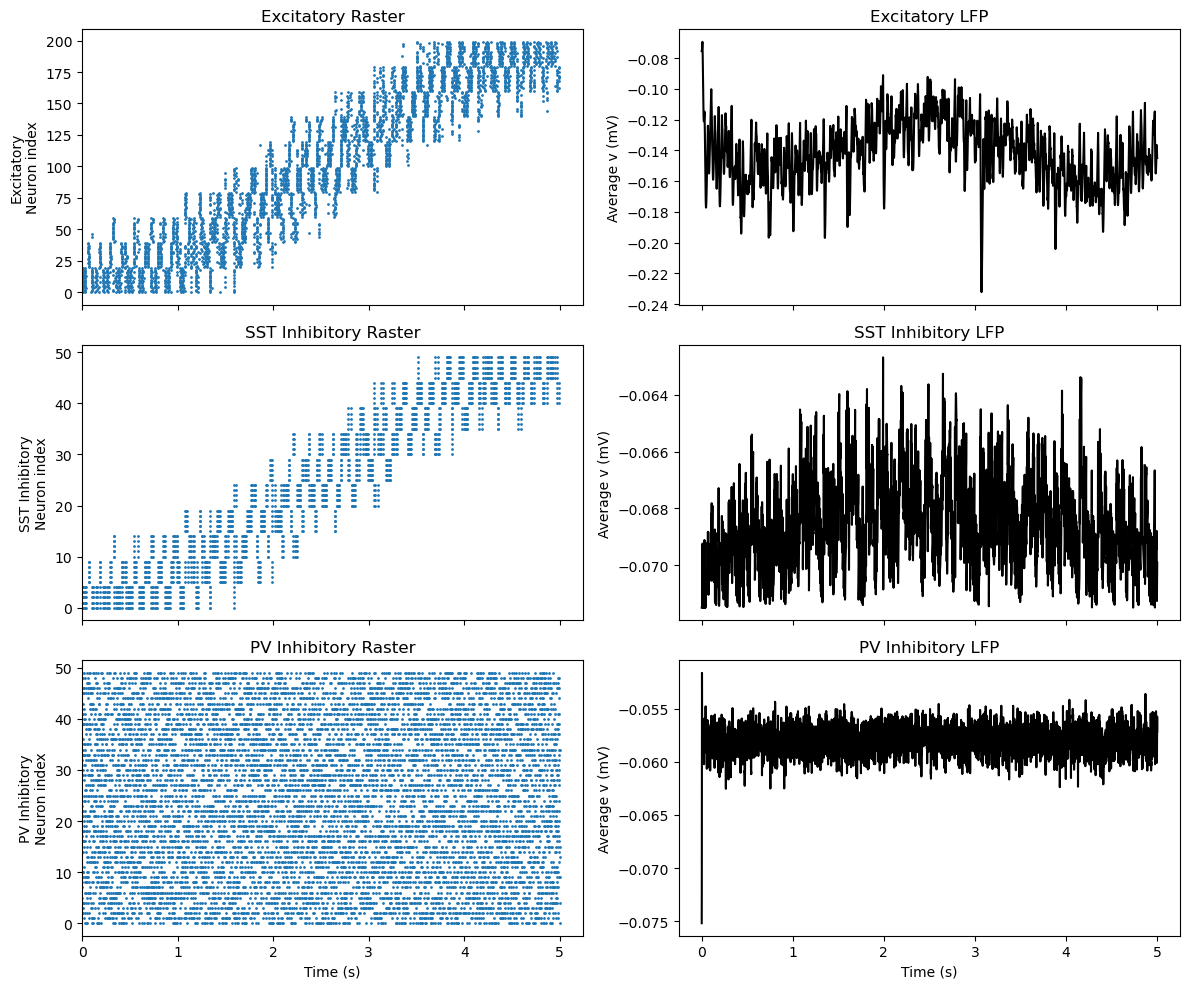

In [2]:
# Convert simulation time from Brian2 units (default: seconds) to a numpy array.
# Here, we assume the state monitors for excitatory cells have recorded the time vector.
time = M_state_exc.t / second  # time in seconds

# Compute the LFPs as the average membrane potential in each population.
LFP_exc = np.mean(M_state_exc.v, axis=0)
LFP_SST = np.mean(M_state_SST.v, axis=0)
LFP_pv  = np.mean(M_state_pv.v, axis=0)

# Create a figure with 3 rows (one per population) and 2 columns:
# left column: raster plot; right column: LFP trace.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex='col')
pop_labels = ['Excitatory', 'SST Inhibitory', 'PV Inhibitory']

# For each population: plot the raster and the LFP.
for i, (spike_mon, lfp, label) in enumerate(zip([M_spike_exc, M_spike_SST, M_spike_pv],
                                                  [LFP_exc, LFP_SST, LFP_pv],
                                                  pop_labels)):
    # Raster plot.
    ax_raster = axes[i, 0]
    # Plot each spike as a small dot; spike_mon.i gives neuron indices.
    ax_raster.plot(spike_mon.t/second, spike_mon.i, '.', markersize=2)
    ax_raster.set_ylabel(f'{label}\nNeuron index')
    ax_raster.set_title(f'{label} Raster')
    ax_raster.set_xlim(0)

    # LFP plot.
    ax_lfp = axes[i, 1]
    ax_lfp.plot(time, lfp, 'k')  # 'k' for a black line.
    ax_lfp.set_ylabel('Average v (mV)')
    ax_lfp.set_title(f'{label} LFP')

# Label the shared X-axis.
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

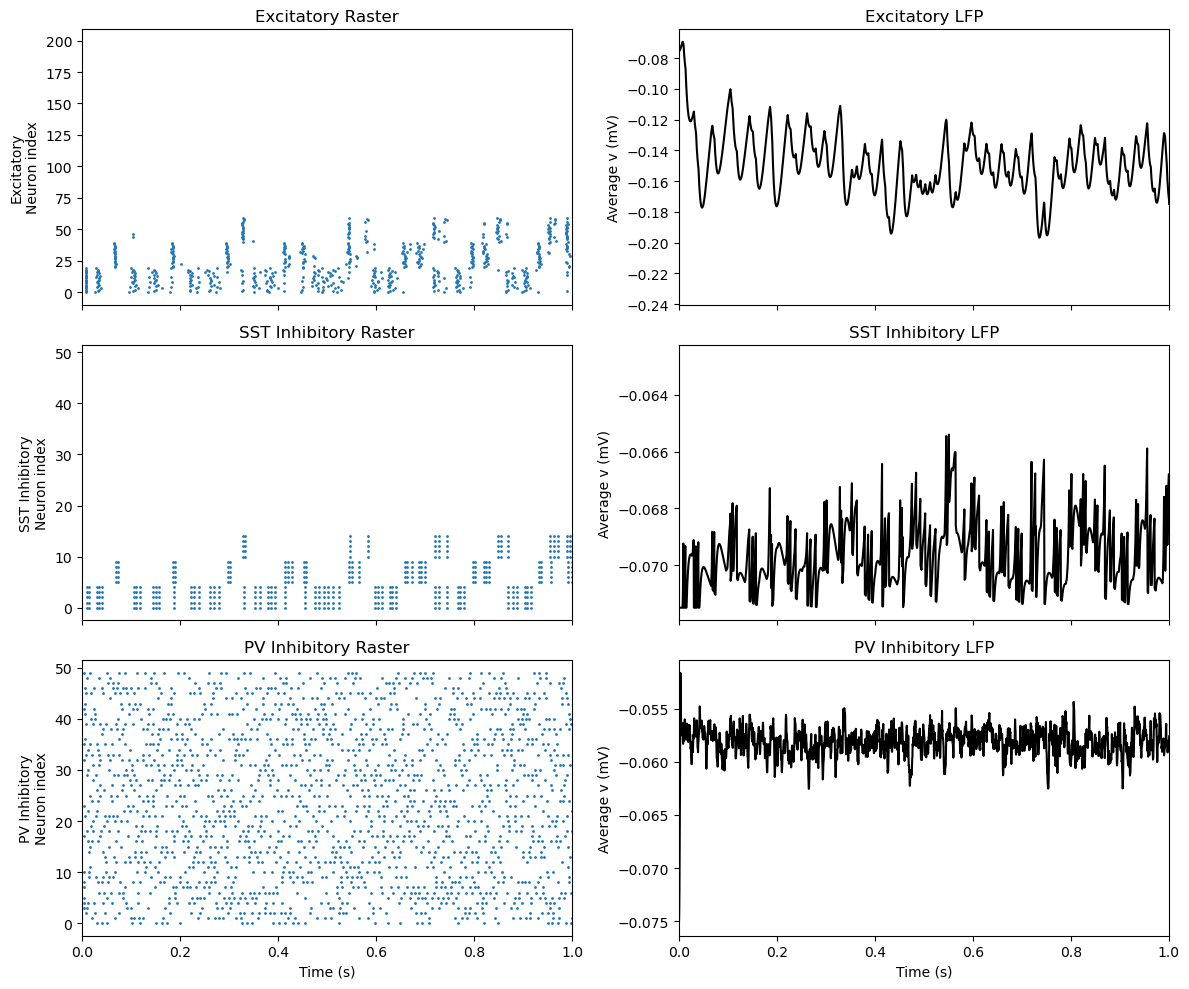

In [3]:
# Convert simulation time from Brian2 units (default: seconds) to a numpy array.
# Here, we assume the state monitors for excitatory cells have recorded the time vector.
time = M_state_exc.t / second  # time in seconds

# Compute the LFPs as the average membrane potential in each population.
LFP_exc = np.mean(M_state_exc.v, axis=0)
LFP_SST = np.mean(M_state_SST.v, axis=0)
LFP_pv  = np.mean(M_state_pv.v, axis=0)

# Create a figure with 3 rows (one per population) and 2 columns:
# left column: raster plot; right column: LFP trace.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex='col')
pop_labels = ['Excitatory', 'SST Inhibitory', 'PV Inhibitory']

# For each population: plot the raster and the LFP.
for i, (spike_mon, lfp, label) in enumerate(zip([M_spike_exc, M_spike_SST, M_spike_pv],
                                                  [LFP_exc, LFP_SST, LFP_pv],
                                                  pop_labels)):
    # Raster plot.
    ax_raster = axes[i, 0]
    # Plot each spike as a small dot; spike_mon.i gives neuron indices.
    ax_raster.plot(spike_mon.t/second, spike_mon.i, '.', markersize=2)
    ax_raster.set_ylabel(f'{label}\nNeuron index')
    ax_raster.set_title(f'{label} Raster')
    ax_raster.set_xlim(0,1)

    # LFP plot.
    ax_lfp = axes[i, 1]
    ax_lfp.plot(time, lfp, 'k')  # 'k' for a black line.
    ax_lfp.set_ylabel('Average v (mV)')
    ax_lfp.set_title(f'{label} LFP')
    ax_lfp.set_xlim(0,1)

# Label the shared X-axis.
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()